# Évaluation - Algorithms in Machine Learning

### Antoine CLÉMENT

# **Improved Regularization of Convolutional Neural Networks with Cutout**

Lien vers l'article de référence : https://arxiv.org/pdf/1708.04552.pdf

Cet article présente les travaux réalisés par Terrance DeVries et Graham W. Taylor de l'université de Guelph au Canada. Leurs recherches concernent une nouvelle technique de régularisation utilisable pour l'entrainement de réseaux de neurones convolutionnels destinés à la reconnaissance d'image. 

### La régularisation dans l'entrainement d'un réseau de neurones

Les réseaux de neurones convolutionnels prennent une part de plus en plus grande dans le domaine de la reconnaissance d'images, et les tâches qu'ils peuvent accomplir sont de plus en plus diverses (reconnaissance d'objets, description du contenu d'une image, estimation de la posture d'une personne...). Avec l'augmentation de la puissance de généralisation nécessaire pour de telles tâches, le nombre de neurones et de couches cachées devient de plus en plus important. Ainsi, il peut y avoir jusqu'à plusieurs centaines de millions de paramètres à optimiser lors de l'entrainement d'un modèle. 

Ce grand nombre de paramètres augmente alors le risque d'overfitting sur les données d'entrainement, conduisant à une faible capacité de généralisation du réseau. Pour éviter ce phénomène, de nombreuses techniques de régularisation ont été développées. Le **Cutout** développé ici est l'une de ces techniques. 

#### État de l'art et enjeux de la régularisation : 
Les techniques de régularisation les plus courantes sont les processus de data augmentation, l'ajout de bruit ou le dropout. Une caractéristique importante pour une bonne technique de régularisation est qu'elle doit être réalisable avec un faible coût de calcul. En effet, elle doit pouvoir être applicable à un large jeu de données sans trop dégrader les performances d'apprentissage du réseau. C'est donc un point important à prendre en compte dans l'étude de cette technique, et la raison pour laquelle les techniques de data augmentation sont très utilisées dans ce domaine. (transformations miroirs, cropping de l'image...)

Mais le dropout est également très utilisé dans l'apprentissage machine, et il se rapproche de la technique mise en place ici. Pour rappel, il s'agit de modifier la fonction d'activation d'un neurone en l'annulant avec une certaine probabilité *p* lors de chaque boucle forward au cours de l'apprentissage ([documentation pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)). Bien que le dropout soit utilisable pour des couches convolutionnelles ou *fully-connected*, il apparait souvent moins efficace pour des couches convolutionnelles pour deux raisons : 
- Les couches convolutionnelles présentent moins de paramètres que les couches *fully-connected*, et requièrent ainsi moins de régularisation.
- Les pixels proches les uns des autres portent souvent la même information et les neurones adjacent des neurones coupées transmettent toujours cette information. 

Toutes ces techniques visent à diminuer le phénomène de co-adaptation, qui se produit lorsque plusieurs neurones font un travail hautement corrélé (positivement ou négativement). Il en résulte que certains neurones ne servent à rien dans le fonctionnement final du réseau, ce qui représente un fonctionnement sous-optimal.

Plus d'informations concernant [la co-adaptatation dans un réseau de neurones](https://datascience.stackexchange.com/questions/36064/what-is-coadaptation-of-neurons-in-neural-networks) ou [la capacité du dropout à réduire cette co-adaptation](https://medium.com/@lipeng2/dropout-is-so-important-e517bbe3ffcc).


## Le cutout

<img src="data/Illustration-cutout.png" alt="cutout" style="width: 400px;"/>
Le cutout est une technique de régularisation complémentaire, qui permet de lutter contre les phénomènes de sur-apprentissage. <br>


Il consiste à appliquer un masque à chaque image lors de son préprocessing. Ainsi, l'apprentissage ne se fait plus sur la zone masquée d'une image, et le réseau doit alors utiliser le contexte d'un objet, et utiliser l'image de manière globale, plutôt que de se concentrer sur quelques petits éléments clés. <br><br>
Il est possible de voir cette transformation comme une forme de dropout, avec cependant deux particularités : 
- Les fonctions d'activations ne sont coupées que sur la première couche du réseau (la couche d'entrée)
- Les fonctions d'activation sont coupées sur toute une zone continue de l'image, et non sur des points disséminés aléatoirement dans l'image d'entrée

Intuitivement, il apparait que cette modification d'une zone continue de l'espace permet de lever un des blocages du dropout développé ci-dessus : le fait que les informations portées par un pixels se retrouvent souvent dans les pixels voisins. Le cutout va ainsi permettre d'être plus efficace que ne le serait le drop-out sur une couche convolutionnelle. 

De plus, il est important de comprendre que ce masque de la couche d'entrée se propage sur toutes les feature-map des couches cachées, ce qui résulte en une absence totale de la zone cachée dans la représentation finale de l'image. 

Cette technique étant très simple à mettre en oeuvre, elle peut facilement être parallélisée et elle ne nécessite pas de *rescaling* des poids lors de l'entrainement comme c'est le cas avec le dropout. Le surplus de coût de calcul est donc très faible. 


De plus, elle est indépendante des autres méthodes de régularisation présentées ci-dessus, et peut donc être utilisée en complément. Dans leurs travaux, les deux chercheurs ont par exemple utilisé un réseau avec du dropout sur les couches linéaires, ainsi que des transformations miroirs et du cropping aléatoire des images. 

## Implémentation

Pour mettre en évidence la méthode du cutout, j'ai choisi de travailler sur le jeu de de données Fashion-MNIST que nous avons déjà utilisé en cours de deep-learning. Il s'agit d'un jeu de données composé de 60.000 images de taille 28x28x1 représentant des vêtements ou accessoires.<br>
Comme nous l'avons fait en cours, j'ai choisi de ne travailler que sur 15% du jeu de données afin d'accélérer les apprentissages à réaliser, et rendre ce notebook utilisable dans le temps imparti. 

<div class="alert alert-success">
Quelques imports classiques.
</div>
 Ce notebook ne devrait pas nécessiter de librairie particulière en plus de celles nécessaires au cours de SDD.

In [4]:
import numpy as np
from typing import Callable

import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

import ignite.engine
import ignite.handlers
import ignite.metrics
import ignite.utils
from ignite.engine import Events

import seaborn as sns

from cutout import Cutout
from utils import iterate_on_model
from utils import find_best_cutout_size
from utils import model_fn

%matplotlib inline

<div class="alert alert-success">
L'étape de Cutout se fait lors du pipe de transformation.
</div>

On réalise l'initialisation :

In [5]:
transform_training = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.2867], std=[0.3205]),  ### Cette normalisation est détaillée après l'explication du processus de Cutout
])

transform_validation = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.2867], std=[0.3205]),  ### Cette normalisation est détaillée après l'explication du processus de Cutout
])

La fonction utilisée pour le Cutout est très simple, et fonctionne sur le principe suivant :<br>
```
h = img.size(1)
w = img.size(2)
mask = np.ones((h, w), np.float32) ## mask only contains 1 

y = np.random.randint(h)
x = np.random.randint(w)

y1 = y - length // 2
y2 = y + length // 2
x1 = x - length // 2
x2 = x + length // 2

mask[y1: y2, x1: x2] = 0          ## some elements of the mask are set to 0

img = img * mask
```

Le code complet se trouve dans le fichier `cutout.py`<br><br>
D'après les chercheurs, la forme de la zone occultée n'a que peu d'importance pour l'optimisation du réseau de neurones. Ainsi, nous utilisons une forme carrée, de taille fixée pour toutes les transformations. <br>
Le détail du choix de cette taille est présenté en annexe. <br>

La zone occultée est sélectionnée en choisissant de manière aléatoire un point central et en formant un carré autour de celui-ci. Le carré peut donc déborder de l'image, et une plus petite zone est alors occultée. D'après les chercheurs, ce fonctionnement est obligatoire et critique pour le bon fonctionnement du réseau de neurones.

Une alternative à laisser déborder le masque d'occlusion est également de ne l'appliquer qu'avec une probabilité de 50%, mais je n'ai pas exploré cette piste ici. 

<div class="alert alert-success">
On ajoute le Cutout au pipe de transformation du jeu d'entrainement uniquement.<br>
En effet, il n'y a pas lieu d'utiliser cette transformation sur le jeu de validation, ce qui justifie la présence de deux pipe distincts.
</div>

In [6]:
n_holes = 1
hole_length = 4

transform_training.transforms.append(    
    Cutout(n_holes, hole_length)
)

<div class="alert alert-success">
Les datasets sont importés, en utilisant le pipe adéquat.
</div>
Pour mener à bien mes recherches dans le temps impartit, j'ai choisi d'entrainer mon réseau sur uniquement 15% du set d'entrainement, et de le tester sur 10% du jeu de test.

In [7]:
seed = 12
labels_text = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


full_trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform_training)
trainset, _ = torch.utils.data.random_split(full_trainset, (10000, 50000), generator=torch.Generator().manual_seed(seed))

full_validset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform_validation)                                           
validset, _ = torch.utils.data.random_split(full_validset, (1000, 9000), generator=torch.Generator().manual_seed(seed))

print(len(trainset))
print(len(validset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False, num_workers=2)

10000
1000


<div class="alert alert-success">
Normalisation des datasets
</div>

Le processus de cutout consiste à occulter une partie de l'image pour qu'elle n'intervienne pas dans l'entrainement du réseau. Nous choisissons donc de mettre à 0 les valeurs des pixels masqués. Mais pour que cela soit un masquage neutre pour le réseau il faut que les valeurs soient centrées autour de 0 et réduites **par canal**. Nos images sont en noir et blanc et n'ont donc qu'un seul canal. Il faut alors connaître la moyenne et l'écart type du canal du jeu d'entrainement pour pouvoir normaliser les données :

In [8]:
mean = 0
std = 0
for images, _ in trainloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= ( len(trainloader.dataset))
std  /= ( len(trainloader.dataset))

print('mean : ', mean)
print('std : ', std)

mean :  tensor([-0.0010])
std :  tensor([0.9918])


Ces valeurs sont ensuite utilisées dans le pipe de normalisation.<br><br>
NB : Ici, le pipe de normalisation est déjà configuré pour les datasets de travail. Vous devriez donc obtenir des valeurs proches de 0 et 1. <br><br>
NB2: Comme j'utilise un jeu d'entrainement très réduit par rapport au jeu d'entrainement global, la valeur de la moyenne et de l'écart type dépendent de l'échantillonnage aléatoire qui est fait. Afin de parvenir à correctement normaliser les datasets, j'utilise donc une graine `seed = 12` pour obtenir toujours les mêmes datasets et utiliser les mêmes moyennes et écarts types.

<div class="alert alert-success">
Visualisation des données
</div>

On observe bien sur quelques échantillons la zone masquée de l'image

(1, 28, 28)

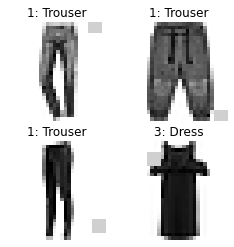

In [17]:
# get the first batch of images and labels
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(4,4))
for i in range(4):
    l = labels[i].numpy()
    plt.subplot(2, 2, i+1)
    plt.title('%d: %s' % (l, labels_text[l]))
    plt.imshow(images[i].numpy()[0], cmap='Greys')
    plt.axis('off')
    
images[0].numpy().shape

<div class="alert alert-success">
Définition du réseau et mise en place de l'entrainement
</div>

L'entrainement du réseau est ensuite similaire à ce que l'on a déjà eu l'occasion de pratiquer en cours d'AML.

Pour cet exercice, le réseau utilisé est un petit réseau convolutionnel basique avec deux couches convolutionnelles. Il est similaire à celui vu en cours et j'ai également repris les principaux paramètres d'entrainement qui y étaient utilisés.

NB : J'ai fait très peu d'optimisations sur ce réseau convolutionnel. J'ai seulement cherché à avoir un réseau avec des performances correctes et assez rapide à entrainer afin de pouvoir travailler sur l'optimisation des hyperparamètres. Mon but ici n'a pas été d'obtenir les meilleures performances possibles avec un réseau convolutionnel, mais de mettre en évidence l'apport du cutout sur un réseau donné.

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model_fn() # the model is defined in the file utils.py to avoid duplicated code

# moving model to gpu if available
model.to(DEVICE)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=600, bias=True)
  (10): Dropout2d(p=0.25, inplace=False)
  (11): Linear(in_features=600, out_features=120, bias=True)
  (12): Linear(in_features=120, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [8]:
# declare optimizers and loss
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

In [9]:
# defining the number of epochs
#epochs = 24 # Here we use a smaller number of epochs to speed up the execution of the notebook (only for this evaluation)
epochs = 5 

# creating trainer
trainer = ignite.engine.create_supervised_trainer(model=model, optimizer=optimizer, loss_fn=criterion, device=DEVICE)

# create metrics
metrics = {
    "accuracy": ignite.metrics.Accuracy(),
    "nll": ignite.metrics.Loss(criterion),
    "cm": ignite.metrics.ConfusionMatrix(num_classes=10),
}

ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

# Evaluators
train_evaluator = ignite.engine.create_supervised_evaluator(model, metrics=metrics, device=DEVICE)
val_evaluator = ignite.engine.create_supervised_evaluator(model, metrics=metrics, device=DEVICE)

# Logging
train_evaluator.logger = ignite.utils.setup_logger("train")
val_evaluator.logger = ignite.utils.setup_logger("val")

# init variables for logging
training_history = {"accuracy": [], "loss": []}
validation_history = {"accuracy": [], "loss": []}
last_epoch = []

In [10]:
# Save the model
model_name = "basic_cnn"
dataset_name = "Fashion_MNIST"

checkpointer = ignite.handlers.ModelCheckpoint(
    "./saved_models",
    filename_prefix=dataset_name,
    n_saved=2,
    create_dir=True,
    save_as_state_dict=True,
    require_empty=False,
)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {model_name: model})

In [11]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(trainloader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics["accuracy"] * 100
    loss = metrics["nll"]
    last_epoch.append(0)
    training_history["accuracy"].append(accuracy)
    training_history["loss"].append(loss)
    print(
        "Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
            trainer.state.epoch, accuracy, loss
        )
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(validloader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics["accuracy"] * 100
    loss = metrics["nll"]
    validation_history["accuracy"].append(accuracy)
    validation_history["loss"].append(loss)
    print(
        "Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
            trainer.state.epoch, accuracy, loss
        )
    )

@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(validloader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = labels_text
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

<div class="alert alert-success">
Entrainement du modèle et visualisation des résultats :
</div>

2021-01-06 22:36:57,007 train INFO: Engine run starting with max_epochs=1.
2021-01-06 22:36:59,491 train INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-06 22:36:59,493 train INFO: Engine run complete. Time taken: 00:00:02
2021-01-06 22:36:59,501 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 1  Avg accuracy: 67.04 Avg loss: 1.78


2021-01-06 22:36:59,804 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2021-01-06 22:36:59,805 val INFO: Engine run complete. Time taken: 00:00:00


Validation Results - Epoch: 1  Avg accuracy: 65.30 Avg loss: 1.79


2021-01-06 22:37:07,017 train INFO: Engine run starting with max_epochs=1.
2021-01-06 22:37:09,273 train INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-06 22:37:09,274 train INFO: Engine run complete. Time taken: 00:00:02
2021-01-06 22:37:09,283 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 2  Avg accuracy: 70.12 Avg loss: 1.36


2021-01-06 22:37:09,556 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2021-01-06 22:37:09,557 val INFO: Engine run complete. Time taken: 00:00:00


Validation Results - Epoch: 2  Avg accuracy: 68.40 Avg loss: 1.38


2021-01-06 22:37:16,362 train INFO: Engine run starting with max_epochs=1.
2021-01-06 22:37:18,835 train INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-06 22:37:18,837 train INFO: Engine run complete. Time taken: 00:00:02
2021-01-06 22:37:18,846 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 3  Avg accuracy: 72.84 Avg loss: 1.11


2021-01-06 22:37:19,159 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2021-01-06 22:37:19,161 val INFO: Engine run complete. Time taken: 00:00:00


Validation Results - Epoch: 3  Avg accuracy: 70.70 Avg loss: 1.13


2021-01-06 22:37:27,285 train INFO: Engine run starting with max_epochs=1.
2021-01-06 22:37:30,374 train INFO: Epoch[1] Complete. Time taken: 00:00:03
2021-01-06 22:37:30,376 train INFO: Engine run complete. Time taken: 00:00:03
2021-01-06 22:37:30,387 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 4  Avg accuracy: 73.90 Avg loss: 0.95


2021-01-06 22:37:30,731 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2021-01-06 22:37:30,733 val INFO: Engine run complete. Time taken: 00:00:00


Validation Results - Epoch: 4  Avg accuracy: 72.20 Avg loss: 0.97


2021-01-06 22:37:38,267 train INFO: Engine run starting with max_epochs=1.
2021-01-06 22:37:40,759 train INFO: Epoch[1] Complete. Time taken: 00:00:02
2021-01-06 22:37:40,760 train INFO: Engine run complete. Time taken: 00:00:02
2021-01-06 22:37:40,769 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 5  Avg accuracy: 74.73 Avg loss: 0.85


2021-01-06 22:37:41,067 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2021-01-06 22:37:41,069 val INFO: Engine run complete. Time taken: 00:00:00
2021-01-06 22:37:41,077 val INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 5  Avg accuracy: 73.40 Avg loss: 0.88


2021-01-06 22:37:41,357 val INFO: Epoch[1] Complete. Time taken: 00:00:00
2021-01-06 22:37:41,359 val INFO: Engine run complete. Time taken: 00:00:00


State:
	iteration: 785
	epoch: 5
	epoch_length: 157
	max_epochs: 5
	output: 0.9912205338478088
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

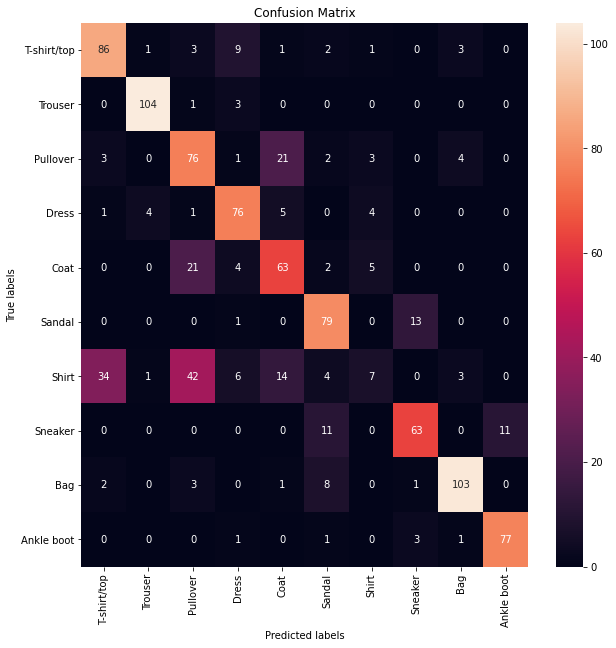

In [12]:
trainer.run(trainloader, max_epochs=epochs)

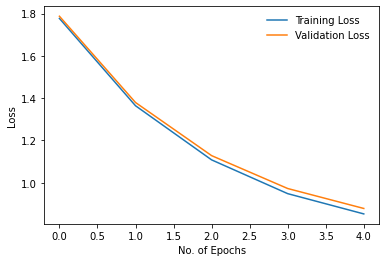

In [13]:
plt.plot(training_history["loss"], label="Training Loss")
plt.plot(validation_history["loss"], label="Validation Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

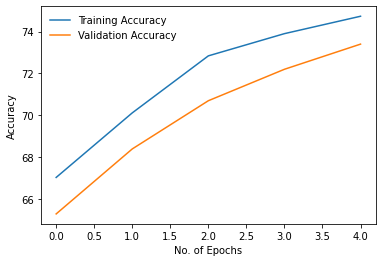

In [14]:
plt.plot(training_history["accuracy"], label="Training Accuracy")
plt.plot(validation_history["accuracy"], label="Validation Accuracy")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

On peut déjà observer que les courbes ressemblent bien à des courbes d'apprentissage classiques.

<div class="alert alert-success">
Bien que l'objectif ne soit pas ici d'avoir la meilleure efficacité possible, cette partie permet de visualiser les éléments mal classifiés 
</div>

In [ ]:
# %load data/code1.py
#creating iterator for iterating the dataset
dataiter = iter(validloader)
images, labels = dataiter.next()
images_arr = []
labels_arr = []
pred_arr = []
# moving model to cpu for inference 
model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,10):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze(), cmap = 'Greys')
    ax.set_title("{} ({})".format(labels_text[pred_arr[i]], labels_text[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))

<div class="alert alert-success">
Itération sur plusieurs entrainements 
</div>

Afin de gagner en robustesse, nous itérons la totalité de ce processus 5 fois pour connaître les performances de ce réseau. La fonction `iterate_on_model` est un simple wrapper permettant de réinitialiser les poids du réseau et de réaliser un entrainement sur 24 périodes. 

<div class="alert alert-danger">
/!\ L'exécution de cette cellule est très longue, ses résultats vous sont présentés ci-dessous
</div>

In [16]:
nb_epochs = 24
train_stats = []
for i in range(5):
    print('\n', f"iteration : {i + 1}")
    train_stats.append(iterate_on_model(nb_epochs, DEVICE, trainloader, validloader))


 iteration : 1
************************
 iteration : 2
************************
 iteration : 3
************************
 iteration : 4
************************
 iteration : 5
************************

In [17]:
##############################################
# To remove if the previous cell is executed #
train_stats = [[0, 0, 0, 0]]                 #
##############################################

train_stats = np.array(train_stats)
train_stats = np.around(train_stats, 2)

avg_training_accuracy = np.mean(train_stats[:,0])
avg_validation_accuracy = np.mean(train_stats[:,1])
avg_training_loss = np.mean(train_stats[:,2])
avg_validation_loss = np.mean(train_stats[:,3])

std_training_accuracy = np.std(train_stats[:,0])
std_validation_accuracy = np.std(train_stats[:,1])
std_training_loss = np.std(train_stats[:,2])
std_validation_loss = np.std(train_stats[:,3])


##############################################
# To remove if the previous cell is executed #
avg_training_accuracy = 82.04                #
avg_validation_accuracy = 78.94              #
avg_training_loss = 0.51                     #
avg_validation_loss = 0.56                   #
                                             #
std_training_accuracy = 0.09                 #
std_validation_accuracy = 0.37               #
std_training_loss = 0.00                     #
std_validation_loss = 0.00                   #
##############################################


print('avg_training_accuracy     :', np.around(avg_training_accuracy, 2), '+/-', np.around(std_training_accuracy, 2))
print('avg_validation_accuracy   :', np.around(avg_validation_accuracy, 2), '+/-', np.around(std_validation_accuracy, 2))
print('avg_training_loss         : ', np.around(avg_training_loss, 2), '+/-', np.around(std_training_loss, 2))
print('avg_validation_loss       : ', np.around(avg_validation_loss, 2), '+/-', np.around(std_validation_loss, 2))

avg_training_accuracy     : 82.04 +/- 0.09
avg_validation_accuracy   : 78.94 +/- 0.37
avg_training_loss         :  0.51 +/- 0.0
avg_validation_loss       :  0.56 +/- 0.0


## Résultats obtenus

Afin de connaître les performances du cutout, nous comparons ces performances à celles du même réseau sans le cutout: (résultats obtenus pour 5 entrainement du réseau)

||Avec Cutout|Sans Cutout|
|-|------|-----|
|training_accuracy|82.04 +/- 0.09|82.91 +/- 0.49|
|validation_accuracy|78.94 +/- 0.37|80.08 +/- 1.11|
|training_loss| 0.51 +/- 0.0|0.48 +/- 0.01|
|validation_loss| 0.56 +/- 0.0|0.55 +/- 0.01|

**Comme on peut le voir, mes travaux n'ont pas permis de confirmer l'apport du cutout, et les résultats décris dans ce papier.**

## Résultats obtenus par les chercheurs **Terrance DeVries** et **Graham W. Taylor**

Leurs recherches se sont concentrées sur trois jeux de données : 
- [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) qui comprend 60.000 images en couleurs de dimension 32x32, et 10 classes à déterminer
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) qui comprend 60.000 images en couleurs de dimension 32x32, et 100 classes à déterminer (certaines très proches comme érable, chêne, palmier, pin et saule)
- Street View House Numbers ([SVHN](http://ufldl.stanford.edu/housenumbers/)) qui comprend 630 420 images en couleur de taille 32x32 contenant un numéro de 1 à 10 à identifier. 

Les réseaux utilisés pour l'entrainement sont des réseaux convolutionnels ([ResNet18](https://www.researchgate.net/figure/ResNet-18-Architecture_tbl1_322476121), [WRN-28-10](http://www.bmva.org/bmvc/2016/papers/paper087/paper087.pdf), et [shake-shake Regularization](https://arxiv.org/abs/1705.07485) qui détenait alors les meilleures performances sur les datasets CIFAR)

L'application du cutout à ces algorithmes a permis d'obtenir les résultats suivants. (l'ensemble des résultats est disponible dans l'article, mais seuls les plus importants sont présentés ici). <br>
C'est ici le taux d'erreur sur l'ensemble de test qui est représenté, avec des valeurs calculées sur 5 entrainement de chaque réseau (3 pour la régularisation shake-shake).

||C10|C100|SVHN|
|-|-|-|-|
|WideResNet|3.87 ± 0.08|18.8 ± 0.08 |1.60 ± 0.05 |
|WideResNet + Cutout |3.08 ± 0.16|18.41 ± 0.27|1.30 ± 0.03|
|Shake-shake regularization|2.86|15.85 |--|
|Shake-shake regularization + Cutout|**2.56 ± 0.07**|**15.20 ± 0.21**|--|

Comme on peut le voir, le cutout augmente bien la performance de ces réseaux convolutionnels, en permettant de diminuer le taux d'erreurs sur l'ensemble de test.<br>
Il est également à noter que ces travaux ont permis **d'établir une nouvelle valeur de l'état de l'art pour les datasets CIFAR** en dépassant la valeur actuelle réalisée par la *shake-shake regularization*.

En observant la répartition et l'intensité des fonctions d'activation des neurones, les scientifiques ont également pu établir que le cutout encourage le réseau à considérer un plus grand nombre de features pour sa classification. 

### Annexes

#### Détermination de la taille optimale pour la zone d'obstruction 

Afin de connaître cette taille optimale, j'ai procédé à une optimisation de cet hyperparamètre avec plusieurs entrainements pour chacune d'entre elle. La fonction suivante est ainsi un wrapper réalisant ce travail, et produisant la moyenne et l'écart type des performances pour chaque taille de zone croppée.

In [21]:
res = find_best_cutout_size(range(1, 22, 3), 1, 1)


 size :  1 

try : 1
**

 size :  4 

try : 1
**

 size :  7 

try : 1
**

 size :  10 

try : 1
**

 size :  13 

try : 1
**

 size :  16 

try : 1
**

 size :  19 

try : 1
**


In [24]:
display(res)

{1: [65.91, 62.8, 1.7319117095947265, 1.75547372341156, 0.0, 0.0, 0.0, 0.0],
 4: [62.91, 61.4, 1.861712300491333, 1.8746537103652954, 0.0, 0.0, 0.0, 0.0],
 7: [60.33,
  60.099999999999994,
  1.7980260103225707,
  1.812066023826599,
  0.0,
  0.0,
  0.0,
  0.0],
 10: [60.88, 60.4, 1.7533258306503297, 1.7778621225357056, 0.0, 0.0, 0.0, 0.0],
 13: [55.47,
  53.800000000000004,
  1.8295123878479005,
  1.8369245138168335,
  0.0,
  0.0,
  0.0,
  0.0],
 16: [51.129999999999995,
  48.3,
  1.9584477298736571,
  1.9805200338363647,
  0.0,
  0.0,
  0.0,
  0.0],
 19: [50.019999999999996,
  49.0,
  1.9758577157974244,
  1.9820405158996581,
  0.0,
  0.0,
  0.0,
  0.0]}

NB : Ce wrapper n'est pas parfait, car il permet un phénomène de data leakage. En effet, ce sont les performances sur le jeu de validation qui sont utilisées pour choisir la taille idéale, alors que c'est également celui-ci qui sert à mesurer les performances du réseau final avec ou sans cutout. Il aurait été mieux de faire intervenir un troisième jeu de données (de test) que le réseau n'aurait jamais vu avant le test final, mais par manque de temps j'ai gardé cette solution, plus proche de nos travaux en SDD. 

C'est le chiffre de 4 que j'ai retenu pour les données que j'ai choisi de traiter car c'est celui qui dans certains cas semblait donner les meilleures performances, mais cela n'a pas permis de significativement améliorer le comportement du réseau.

#### Cout du processus de cutout :

Afin de mesurer le surcout que cette méthode entraine, nous pouvons comparer le temps mis pour charger l'ensemble du dataset :

In [20]:
def load_dataset(cutout, data_augmentation, random_cropping):
    transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

    if cutout : 
        transform.transforms.append(    
            Cutout(1, 4)
        )
    
    if data_augmentation : 
        transform.transforms.append(transforms.RandomHorizontalFlip())
        
    if random_cropping : 
        transform.transforms.append(transforms.RandomCrop(25, padding=4))
    

    trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=60, shuffle=True, num_workers=2)

    dataiter = iter(trainloader)
    for i in range(1000): #data set has size 60.000 and batches has size 60
        images, labels = dataiter.next()

In [21]:
%%time 
## No data-transformation
load_dataset(False, False, False)

CPU times: user 288 ms, sys: 160 ms, total: 448 ms
Wall time: 3.18 s


In [22]:
%%time
## random_flip
load_dataset(False, True, False)

CPU times: user 280 ms, sys: 151 ms, total: 432 ms
Wall time: 4.88 s


In [23]:
%%time 
## Random Cropping
load_dataset(False, False, True)

CPU times: user 335 ms, sys: 176 ms, total: 510 ms
Wall time: 6.27 s


In [24]:
%%time 
## Cutout
load_dataset(True, False, False)

CPU times: user 373 ms, sys: 190 ms, total: 563 ms
Wall time: 8.6 s


In [25]:
%%time 
## All transformations
load_dataset(True, True, True)

CPU times: user 317 ms, sys: 166 ms, total: 483 ms
Wall time: 12.5 s


On observe que même si individuellement le processus de cutout est plus long que d'autres prétraitements, la parallèlisation du processus permet de diminuer cet impact négatif, qui est de plus minime par rapport au temps total nécessaire pour entrainer le réseau. 

### Raisons de l'échec de mes essais
Je vois deux raisons possibles à l'échec de mes expérimentations pour reproduire le résultat des chercheurs :
- Mes images sont en noir et blanc, alors que celles des chercheurs étaient en couleur. <br> 
Cela implique que le cutout est "trois fois" moins efficaces car seulement un canal est occulté au lieu des trois dans l'autre cas
- Mes images ont une petite taille, avec beaucoup de blanc autour de l'image. <br>
Ainsi, si le cutout tombe dans une zone blanche, il produit seulement du bruit sur l'image, et il ne reste plus beaucoup d'information dans l'image une fois le masque réalisé. De plus, le cutout pousse le réseau à utiliser le contexte de l'image pour son entrainement, or les images de ce dataset ne présentent pas vraiment de contexte.

J'ai choisi de ne pas utiliser les mêmes supports que les chercheurs car les temps d'entrainement étaient rédhibitoires, et que travailler sur le jeu de données Fashion-MNIST permettait un plus grand parallèle avec nos activités en SDD, mais cela ne s'est pas révélé être un choix pertinent. 

## Pour aller plus loin

###  Réutilisation du cutout

Bien que ma démonstration ne soit pas très probante, les résultats des chercheurs sont tout de même prometteurs. Si vous souhaitez vous aussi mettre en place ce prétraitement des données, il vous suffit simplement d'inclure la couche de cutout au sein du pipe de transformation en utilisant le fichier `cutout.py` que j'utilise moi-même. L'étape la plus délicate sera de choisir la meilleure taille pour la zone à masquer, ce que vous pouvez faire comme je l'ai fait, ou à l'aide d'une cross validation. 

### Bibliographie

Les ressources que j'ai utilisées tout au long de ce notebook sont les suivantes : 

Article de référence : https://arxiv.org/pdf/1708.04552.pdf <br><br>
Documentation concernant la co-adaptation et le dropout :<br>
https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout<br>
https://datascience.stackexchange.com/questions/36064/what-is-coadaptation-of-neurons-in-neural-networks<br>
https://medium.com/@lipeng2/dropout-is-so-important-e517bbe3ffcc<br><br>
Réseaux et datasets de référence : <br>
https://www.cs.toronto.edu/~kriz/cifar.html<br>
https://www.cs.toronto.edu/~kriz/cifar.html<br>
http://ufldl.stanford.edu/housenumbers/<br><br>
https://www.researchgate.net/figure/ResNet-18-Architecture_tbl1_322476121<br>
http://www.bmva.org/bmvc/2016/papers/paper087/paper087.pdf<br>
https://arxiv.org/abs/1705.07485<br>
https://github.com/uoguelph-mlrg/Cutout<br>